# Analysis of lysine desert regions in selected proteomes

# 1. Import libraries

In [ ]:
import pandas as pd
import re
import numpy as np
import pickle
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.ticker import FixedFormatter
from IPython.display import display, Markdown
import os
import gzip
import statistics
from Bio import SeqIO
from ete3 import NCBITaxa, Tree, TreeStyle, AttrFace, TextFace, add_face_to_node
ncbi = NCBITaxa()

# 2. Read preprocessed data

Read preprocessed data obtained by running `Download_data.ipynb`.

In [ ]:
# Read dictionary with number of predicted Transmembrane Helices for each selected Bacteria/Eukaryota proteome
with open("results/TMH_predictions/tmhmm_dict.pickle", "rb") as fp: 
    TMH_dict = pickle.load(fp)

# 3. Set parameters

In [6]:
# Define lysine desert region minimum length; integer or float
desert_min_lengths = [150, 0.5]
# Define minimum sequence length
seq_min_length = 150
# Define maximum number of predicted Transmembrane Helices (TMH) in sequence
TMH_max = 2.0

CANON_AA = ['A', 'G', 'P', 'V', 'L', 'I', 'M', 'C', 'F', 'Y', 
            'W', 'H', 'K', 'R', 'Q', 'N', 'E', 'D', 'S', 'T']

########################################### LYSINE CLUSTER ##########################################
# Define minimum fraction of total sequence lysines to be in close proximity to form lysine cluster
lysine_cluster_fraction = 0.8
# Define maximum fraction of sequence length to contain defined above fraction of all lysines
lysine_cluster_seq_fraction = 0.2
# Define fraction at the beggining of sequence to be considered as N-terminal
N_term_end_fraction = 0.2
# Define fraction at the end of sequence to be considered as C-terminal
C_term_end_fraction = 0.8
#####################################################################################################

In [20]:
%%bash

mkdir -p results
mkdir -p results/trees
mkdir -p results/trees/pickles
mkdir -p results/charts
mkdir -p results/lysine_clusters
mkdir -p results/heatmaps
mkdir -p results/heatmaps/Eukaryota/all_amino_acids

mkdir -p results/trees/K_deserts
for aa in A G P V L I M C F Y W H K R Q N E D S T; do mkdir -p results/trees/pickles/${aa}_deserts; done

mkdir -p data/pupylome
mkdir -p data/pupylome/pupylated_proteins
mkdir -p data/pupylome/nonpupylated_proteins

# 4. Main code

## 4.1. Lysine desert search algorithm

### Lysine desert region search

We define lysine desert lengths as either:
1. completely lysine-devoid region of minimum 150 aa length
2. completely lysine-devoid region of minimum 50% sequence length

### Algorithm implementation

#### Selection criteria

At first, we select only sequences from proteome which
1. are minimum 150 aa long
2. have predicted number of their Transmembrane Helices (TMH) not exceeding 2.0 (applies only to selected Bacteria and Eukaryota taxons, not to phages, nor all Uniprot reference taxons)

#### Lysine desert search

Next, we count sequences which have lysine-devoid region of declared type (min. 150 aa long or constituing of 50% of sequence length). We report percentage of sequences with such lysine desert region among all selected sequences.

> **_NOTE:_** For each phages' group, we take all filtered sequences, cluster them and treat as "one big proteome", next we calculate percentage of sequences with lysine desert region. 

#### Default parameters

* minimum sequence length = 150 aa
* maximum number of predicted Transmembrane Helices per sequence = 2.0

### Lysine cluster search

In addition to lysine desert region search, each sequence (**if it contains at least 2 lysines**) is checked for the presence of lysine cluster.

By default lysine cluster is defined as ⌊80% * total number of lysines in sequence⌋ within 20% of sequence length. 

We distinguish three types of lysine cluster, according to its position in sequence:
* anywhere in sequence
* at N-end, defined as first 20% of sequence
* at C-end, defined as last 20% of sequence

For each sequence, presence of each lysine cluster type is reported (Yes/No).

In [61]:
class FindDesertProteome():

    def __init__(self, fasta, desert_amino_acid):
        """Open and parse fasta file
        
        :param fasta: path to fasta file
        :type fasta: str
        """

        f = gzip.open(fasta, "rt")
        self.fasta = list(SeqIO.parse(f, 'fasta'))
        self.number = len(self.fasta)
        self.taxon = fasta.split('/')[-1].split('_')[1].split('.')[0]
        self.desert_amino_acid = desert_amino_acid
    
           
    def fasta_filter(self, seq_min_length, TMH_max):
        """Discard sequences shorter than declared minimal length and with exceeded maximum predicted transmembrane helices number
        
        :param  seq_min_length: minimum length of sequence to be considered in analysis
        :type seq_min_length: int
        :param TMH_max: maximum number of predicted Transmembrane Helices per sequence, if None do not apply this filter
        :type TMH_max: int or float or None
        """

        self.minimal_length = seq_min_length

        self.fasta_filtered = []
        
        for seq_record in self.fasta:
            if len(seq_record.seq) >= self.minimal_length:
                
                if TMH_max is not None:
                    name = seq_record.name.split('|')[1]
                    if TMH_dict[self.taxon][name] <= TMH_max:
                        self.fasta_filtered.append(seq_record)
                else:
                    self.fasta_filtered.append(seq_record)

        self.number_filtered = len(self.fasta_filtered)
        
    def avg_seq_length(self):
        """Calculate average sequence length for filtered sequences 
        """

        total_seq_lengths = 0

        for rec in self.fasta_filtered:
            total_seq_lengths += len(rec.seq)
        
        return round(total_seq_lengths / self.number_filtered, 2)
    
    def calculate_aa_frequencies(self, desert_min_length, seq_min_length, which_region, TMH_max=None):
        """Calculate relative aa frequencies in lysine desert regions/whole sequences
        
        :param desert_min_length: minimal lysine-less region length or sequence fraction to consider lysine desert
        :type desert_min_length: int or float
        :param  seq_min_length: minimum length of sequence to be considered in analysis
        :type seq_min_length: int
        :param which_region: describes is aa frequencies should be calculated for lysine desert chunk only or the entire lysine desert-containing sequence
        :type which_region: str
        :param TMH_max: maximum number of predicted Transmembrane Helices per sequence
        :type TMH_max: int or float
        :return: dict with relative frequencies of each of the twenty canonical aa in the desert/whole seq region (relative to the mean among all filtered proteome's sequences)
        :rtype: float
        """
        
        self.fasta_filter(seq_min_length, TMH_max)
        if self.number_filtered == 0:
            return None
                  
        aa_dict_all = {}
        aa_dict_region = {}
        relative_frequencies = {}
        
        for aa in CANON_AA:
            aa_dict_all[aa] = []
            aa_dict_region[aa] = []
        
        for rec in self.fasta_filtered:
            
            for aa in CANON_AA:
                aa_dict_all[aa].append(rec.seq.count(aa)/len(rec.seq))
                
            seq_filtered = ''.join(['1' if aa != self.desert_amino_acid else '0' for aa in rec.seq])
            # Get lysine-less sequence chunks
            desert_indices_all = [(match.start(), match.end()) for match in re.finditer('1+', seq_filtered)] 

            if type(desert_min_length) != int:
                desert_min_calc = int(math.ceil(desert_min_length * len(rec.seq)))
            else:
                desert_min_calc = desert_min_length

            for indice in desert_indices_all:

                start, end = indice
                length = int(end) - int(start)

                if length >= desert_min_calc:
                    if which_region == 'whole_seq':
                        for aa in CANON_AA:
                            aa_dict_region[aa].append(rec.seq.count(aa)/len(rec.seq))
                    elif which_region == 'desert_chunk':
                        for aa in CANON_AA:
                            aa_dict_region[aa].append(rec.seq[start:end].count(aa)/len(rec.seq[start:end]))
                    else:
                        raise Exception('Unknown parameter')

        for aa in CANON_AA:
            aa_dict_all[aa] = statistics.mean(aa_dict_all[aa])
            aa_dict_region[aa] = statistics.mean(aa_dict_region[aa])

        for aa in CANON_AA:
            relative_frequencies[aa] = round(aa_dict_region[aa]/aa_dict_all[aa], 3)
        
        return relative_frequencies
    
    def _check_lysine_cluster(self, seq):
        """Check if each lysine cluster type occurs in sequence. 
        By default, lysine cluster is defined if at least 80% of sequence lysines are within 20% sequence length.
        Minimum number of lysines in sequence is 2 to check it for lysine cluster
        
        :return: information about presence/absence of each lysine cluster type
        :rtype: list
        """
        
        cluster_anywhere = 'No'

        biggest_cluster = 0
        left_idx = []
        right_idx = []
        cluster_max_length = lysine_cluster_seq_fraction * len(seq)

        only_lysine = ''.join(['1' if aa == self.desert_amino_acid else '0' for aa in seq])
        only_lysine_indices = [match.start() for match in re.finditer('1', only_lysine)]

        if len(only_lysine_indices) > 2:
            # by default 1-lysine_cluster_fraction is 1-0.8=0.2; 80% of lysines have to be present to form lysine cluster
            for i in range(math.ceil(len(only_lysine_indices)*(1-lysine_cluster_fraction))+1): 
                for j in range(1,math.ceil(len(only_lysine_indices)*(1-lysine_cluster_fraction))+2-i):
                    if only_lysine_indices[-j] - only_lysine_indices[i] < cluster_max_length:
                        left_idx.append(only_lysine_indices[i])
                        right_idx.append(only_lysine_indices[-j])

            if len(right_idx) > 0:

                cluster_anywhere = 'Yes'
        
        elif len(only_lysine_indices) == 2:
            if only_lysine_indices[1] - only_lysine_indices[0] < cluster_max_length:
                cluster_anywhere = 'Yes'

        return cluster_anywhere 
        
    def find_lysine_deserts_by_sequence(self, desert_min_length, seq_min_length, TMH_max=None):
        """Find lysine deserts regions considering only sequence information
        
        :param desert_min_length: minimal lysine-less region length or sequence fraction to consider lysine desert
        :type desert_min_length: int or float
        :param  seq_min_length: minimum length of sequence to be considered in analysis
        :type seq_min_length: int
        :param TMH_max: maximum number of predicted Transmembrane Helices per sequence
        :type TMH_max: int or float
        :return: percentage of sequences with lysine desert region among all filtered sequences of the proteome
        :rtype: float
        """
        
        self.fasta_filter(seq_min_length, TMH_max)
        
        if self.number_filtered == 0:
            return (None, None, 0)
        
        cluster_counter = 0
        desert_counter = 0
        desert_seq_all = [] # all sequences for all taxons with declared minimal length desert
        cluster_independent_of_desert_counter = 0
        
        for rec in self.fasta_filtered:
            
            seq_filtered = ''.join(['1' if aa != self.desert_amino_acid else '0' for aa in rec.seq])
            # Get lysine-less sequence chunks
            desert_indices_all = [(match.start(), match.end()) for match in re.finditer('1+', seq_filtered)] 
            desert_indices_filtered = []
            
            if type(desert_min_length) != int:
                desert_min_calc = int(math.ceil(desert_min_length * len(rec.seq)))
            else:
                desert_min_calc = desert_min_length

            for indice in desert_indices_all:

                start, end = indice
                length = int(end) - int(start)
                
                if length >= desert_min_calc:
                    desert_indices_filtered.append((start, end))

            if desert_indices_filtered:
                desert_counter += 1
                cluster = self._check_lysine_cluster(rec.seq)
                if cluster == 'Yes':
                    cluster_counter += 1
            
            cluster_independent_of_desert = self._check_lysine_cluster(rec.seq)
            if cluster_independent_of_desert == 'Yes':
                cluster_independent_of_desert_counter += 1
        
        desert_percentage = round(100*(desert_counter/self.number_filtered), 2)

        if desert_counter == 0:
            return (desert_percentage, desert_counter, self.number_filtered, None, round(100*(cluster_independent_of_desert_counter/self.number_filtered), 2))
        else:
            return (desert_percentage, desert_counter, self.number_filtered, round(100*(cluster_counter/desert_counter), 2), round(100*(cluster_independent_of_desert_counter/self.number_filtered), 2))
        

# 5. Run analyses

## 5.1. Search for lysine deserts in selected Bacteria and Eukaryota proteomes

In [22]:
def calculate_lysine_deserts(domain, desert_min_length, seq_min_length, TMH_max, desert_amino_acid):
    """Find lysine desert regions in selected Bacteria/Eukaryota proteomes
    
        :param desert_min_length: minimal lysine-less region length or sequence fraction to consider lysine desert
        :param  seq_min_length: minimum length of sequence to be considered in analysis
        :type seq_min_length: int
        :param tmh_max: maximum number of predicted Transmembrane Helices per sequence
        :type tmh_max: int or float
        :return: dictionary with taxon id as key and percentage of sequences with lysine desert region among all filtered sequences of the proteome as value
    """
        
    proteomes_results = {}
    for proteome in os.listdir('data/{}_proteomes'.format(domain)):
        if proteome == '.DS_Store': continue

        fasta_file = FindDesertProteome('data/{}_proteomes/{}'.format(domain, proteome), desert_amino_acid)
        score = fasta_file.find_lysine_deserts_by_sequence(desert_min_length, seq_min_length, TMH_max)
        taxon = proteome.split('_')[1].split('.')[0]
        proteomes_results[taxon] = score

    return proteomes_results

In [23]:
def run_analysis(domain, seq_min_length, TMH_max, desert_amino_acid):
    for desert_length in desert_min_lengths:
        result = calculate_lysine_deserts(domain, desert_length, seq_min_length, TMH_max, desert_amino_acid)
        save_pickle = 'results/trees/pickles/{}_deserts/{}_desert_{}.pickle'.format(desert_amino_acid, domain, desert_length)
        with open(save_pickle, 'wb') as handle:
            pickle.dump(result, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [24]:
run_analysis('bacteria', seq_min_length, TMH_max, 'K')

In [25]:
run_analysis('eukaryota', seq_min_length, TMH_max, 'K')

### Plot trees

In [26]:
def draw_tree(dictionary, desert_min_length, desert_amino_acid, save_name):
            
    ncbi = NCBITaxa()
    tree = ncbi.get_topology(dictionary.keys())

    def my_layout(node):

        F = TextFace(node.name, fsize=22, tight_text=True)
        add_face_to_node(F, node, column=0 , position="branch-right")

        if node.is_leaf():
            sciname_face = AttrFace("sci_name", fsize = 28, fgcolor = "black")
            node.add_face(sciname_face, column = 0, position = "branch-right")

            label = dictionary.get(node.name)

            taxon = TextFace('    ' + str(label), fsize = 26, tight_text = True, bold=True)
            add_face_to_node(taxon, node, column = 0 , position = "aligned")
            
        else:

            sciname_face = AttrFace("sci_name", fsize = 24, fgcolor = "black")
            node.add_face(sciname_face, column = 0, position = "branch-right")
            if node.name == '314146': # Mouse first, later Primates
                node.swap_children()

    ts = TreeStyle()
    ts.layout_fn = my_layout
    ts.show_leaf_name = False
    ts.optimal_scale_level = "full"
    ts.show_branch_length = False
    ts.show_branch_support = False
    tree.ladderize()

    tree.render('results/trees/{}_deserts/{}.png'.format(desert_amino_acid, save_name), tree_style=ts, units='px', w=3000, dpi=600)

In [27]:
def run_tree_plotting(domain, desert_amino_acid):
    for desert_length in desert_min_lengths:
        with open('results/trees/pickles/{}_deserts/{}_desert_{}.pickle'.format(desert_amino_acid, domain, desert_length), 'rb') as handle:
            results = pickle.load(handle)

        new_dict = {}

        for key in results.keys():
            new_dict[key] = str(results[key][0])+'%'

        draw_tree(new_dict, desert_length, desert_amino_acid, '{}_lysine_desert_min_{}'.format(domain, desert_length))

In [28]:
run_tree_plotting('bacteria', 'K')

In [29]:
run_tree_plotting('eukaryota', 'K')

## 5.2. Search for lysine deserts in all Bacteria UniProt reference proteomes

In [62]:
run_analysis('all_Uniprot_ref_bacteria', seq_min_length, None, 'K')

### Plot trees

We calculated the fraction of lysine desert proteins in each Bacteria UniProt reference proteome (see Selection criteria applied to each proteome in par. 4). However, for plot clarity, we will show the results at the level of bacterial classes, not single taxons.

In [7]:
def draw_tree_all_bacteria(dictionary, desert_min_length, desert_amino_acid, save_name, f2rgb):
            
    ncbi = NCBITaxa()
    tree = ncbi.get_topology(dictionary.keys())

    def my_layout(node):

        F = TextFace(node.name, fsize=50, tight_text=True, bold=True)
        add_face_to_node(F, node, column=0 , position="branch-right")
        
        if node.is_leaf():
            sciname_face = AttrFace("sci_name", fsize = 60, fgcolor = "black")
            node.add_face(sciname_face, column = 0, position = "branch-right")

            #label = dictionary.get(node.name)
            label = dictionary.get(int(node.name))

            taxon = TextFace(str(label)+'%', fsize = 56, tight_text = True, bold=True)
            add_face_to_node(taxon, node, column = 0 , position = "aligned")
            node.img_style["bgcolor"] = colors.rgb2hex(f2rgb.to_rgba(label)[:3])
            
        else:
            sciname_face = AttrFace("sci_name", fsize = 50, fgcolor = "black")
            node.add_face(sciname_face, column = 0, position = "branch-right")

    ts = TreeStyle()
    ts.layout_fn = my_layout
    ts.mode = "c"
    ts.show_leaf_name = False

    tree.render('results/trees/{}_deserts/{}.png'.format(desert_amino_acid, save_name), 
                tree_style=ts,
                dpi=600)

In [8]:
def run_tree_plotting_all_bacteria(desert_amino_acid):
    
    ncbi = NCBITaxa()
    
    for desert_length in desert_min_lengths:
        with open('results/trees/pickles/{}_deserts/all_Uniprot_ref_bacteria_desert_{}.pickle'.format(desert_amino_acid, desert_length), 'rb') as handle:
            results = pickle.load(handle)

        family_not_found = 0
        lineage_not_found = 0
        family_dict = {}
        
        for key in results.keys():
            
            desert_result = float(results[key][0])

            try:
                lineage = ncbi.get_lineage(key)
            except ValueError:
                lineage_not_found += 1
                continue

            ranks = ncbi.get_rank(lineage)

            try:
                family = list(ranks.keys())[list(ranks.values()).index('class')]

                if family not in family_dict.keys():
                    family_dict[family] = []

                family_dict[family].append(desert_result)

            except ValueError:
                family_not_found += 1
        
        # discard classes with less than 10 taxons and calculate mean of lysine desert fractions in proteomes of a given class
        family_dict = {key:round(np.mean(np.array(val)),2) for key, val in family_dict.items() if len(family_dict[key]) >= 10}

        key_max = max(family_dict.keys(), key=(lambda k: family_dict[k]))
        key_min = min(family_dict.keys(), key=(lambda k: family_dict[k]))

        norm = colors.Normalize(vmin=family_dict[key_min] , vmax=family_dict[key_max] + 15)
        f2rgb = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('RdYlGn'))
        
        draw_tree_all_bacteria(family_dict, desert_length, desert_amino_acid, 'All_bacteria_desert_{}'.format(desert_length),f2rgb)


In [9]:
run_tree_plotting_all_bacteria('K')

## 5.3. Calculate frequencies of 20 aa deserts in selected Eukaryota proteomes

### Calculate deserts for each of 20 aa

In [30]:
for aa in CANON_AA:
    run_analysis('eukaryota', seq_min_length, TMH_max, aa)

### Plot heatmaps

In [47]:
def run_heatmap_plotting(domain, desert_length):
    
    if domain == 'eukaryota': 
        proteomes_results = {'Homo sapiens' : [],  'Mus musculus':[],
                             'Drosophila melanogaster' : [], 'Caenorhabditis elegans': [],'Saccharomyces cerevisiae S288C': []}
    
    
    for aa in CANON_AA:
        with open('results/trees/pickles/{}_deserts/{}_desert_{}.pickle'.format(aa, domain, desert_length), 'rb') as handle:
            results = pickle.load(handle)
            for taxon in results.keys():
                proteomes_results[ncbi.get_taxid_translator([taxon])[int(taxon)]].append(results[taxon][0])

    df_aa = pd.DataFrame.from_dict(proteomes_results, orient='index')
    df_aa.columns = CANON_AA
    scaled_df = (df_aa - df_aa.min(axis=0))/(df_aa.max(axis=0) - df_aa.min(axis=0))

    values = np.array(df_aa.values.tolist())
    b = np.argsort(np.argsort(values, axis=0), axis=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,3))
    
    
    plt.xticks(fontsize=20)
    plt.yticks(np.arange(0.5, len(proteomes_results.keys()), 1), proteomes_results.keys(), fontsize=20, rotation=90)

    sns.heatmap(scaled_df, ax=ax, square=True, cbar=False, cmap="coolwarm",
                    annot=df_aa,fmt='.2f', annot_kws={"size": 11})

    cax = fig.add_axes([ax.get_position().x1 +0.01, ax.get_position().y0, 0.008, ax.get_position().height])    
    im = plt.imshow(b, aspect="auto", cmap="coolwarm")
    cb = plt.colorbar(im, ticks=np.array([0.0, 0.5, 1.0])*b.max(), 
                 format=FixedFormatter(["low", "middle", "high"]), cax=cax)
    cb.outline.set_visible(False)
   
    bottom, top = ax.get_ylim()
    fig.savefig('results/heatmaps/{}/all_amino_acids/{}_desert.png'.format(domain.capitalize(), desert_length), dpi=600, bbox_inches='tight')

    plt.show()
    plt.close('all')

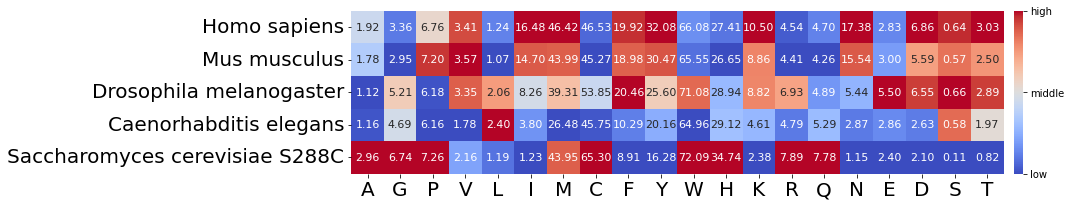

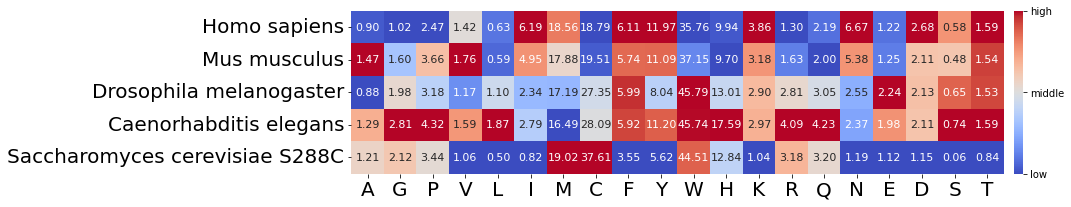

In [48]:
run_heatmap_plotting('eukaryota', 150)
run_heatmap_plotting('eukaryota', 0.5)

## 5.4. Calculate heatmaps of relative amino acids frequencies in selected Eukaryota proteomes

The algorithm is as follows:

1. Filter from the proteome sequences as described in Selection criteria in par. 4.
2. For each sequence fulfilling the above criteria, count number of occurrence of each 20 aa and divide it by the sequence length
3. For each protein with a lysine desert of the defined length, count number of occurrence of each of 20 aa (either only within the lysine desert chunk or in the entire protein sequence) and divide it by the chunk/sequence length
4. Calculate mean of values from point 2
5. Calculate mean of values from point 3
6. Divide values from point 5 by values from point 4 for each aa

In [33]:
%%bash

mkdir -p results/heatmaps
mkdir -p results/heatmaps/Eukaryota

In [42]:
def calculate_aa_frequencies(domain, desert_min_length, seq_min_length, which_region, TMH_max):
    """Calculate avg aa frequencies in selected Bacteria/Eukaryota proteomes
    
        :param desert_min_length: minimal lysine-less region length or sequence fraction to consider lysine desert
        :param  seq_min_length: minimum length of sequence to be considered in analysis
        :type seq_min_length: int
        :param tmh_max: maximum number of predicted Transmembrane Helices per sequence
        :type tmh_max: int or float
        :return: dictionary with taxon id as key and percentage of sequences with lysine desert region among all filtered sequences of the proteome as value
    """
    if domain == 'eukaryota': 
        proteomes_results = {'Homo sapiens' : None, 'Mus musculus':None,
                             'Drosophila melanogaster' : None, 'Caenorhabditis elegans': None,'Saccharomyces cerevisiae S288C': None}
        

    for proteome in os.listdir('data/{}_proteomes'.format(domain.capitalize())):
        if proteome == '.DS_Store': continue

        fasta_file = FindDesertProteome('data/{}_proteomes/{}'.format(domain.capitalize(), proteome), 'K')
        score = fasta_file.calculate_aa_frequencies(desert_min_length, seq_min_length, which_region, TMH_max)
        taxon = proteome.split('_')[1].split('.')[0]
        proteomes_results[ncbi.get_taxid_translator([taxon])[int(taxon)]] = score

    return proteomes_results

In [49]:
def run_analysis_aa_frequencies(domain, seq_min_length, which_region, TMH_max):
    for desert_length in desert_min_lengths:
        
        aa_freqs = calculate_aa_frequencies(domain, desert_length, seq_min_length, which_region, TMH_max)
        # 0 for aa freq of all selected sequences
        
        df_aa = pd.DataFrame.from_dict(aa_freqs, orient='index')
        all_values = []
        for k in aa_freqs.keys():
            for k2 in aa_freqs[k].keys():
                all_values.append(aa_freqs[k][k2])

        ticks = [round(min(all_values)+0.1,1), round((max(all_values)-min(all_values))/2+min(all_values),1),round(max(all_values),1)-0.1]
        fig, ax = plt.subplots(1,1,figsize=(15,3))

        plt.xticks(fontsize=20)
        plt.yticks(np.arange(0.5, len(aa_freqs.keys()), 1), aa_freqs.keys(), fontsize=20, rotation=90)

        sns.heatmap(df_aa, cbar=True,square=True, cmap="coolwarm",cbar_kws={"pad":0.01, "ticks":ticks},
                    annot=True,fmt='.2f', annot_kws={"size": 11})

        plt.show()
        fig.savefig('results/heatmaps/{}/{}_desert_{}_{}.png'.format(domain.capitalize(), domain.capitalize(), desert_length, which_region), dpi=600, bbox_inches='tight')

        plt.close("all")

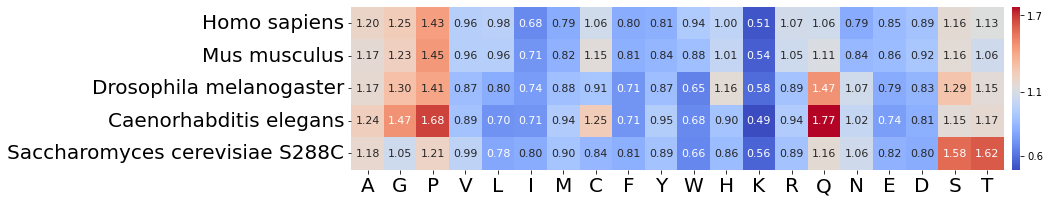

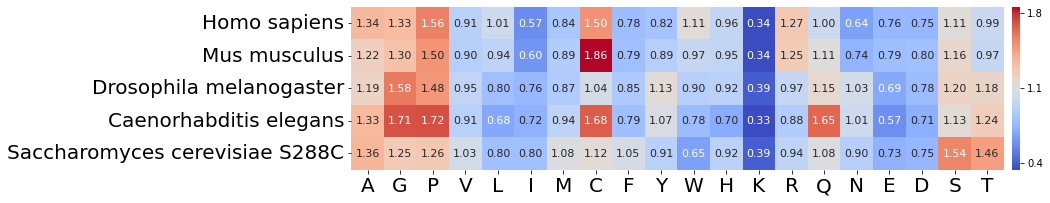

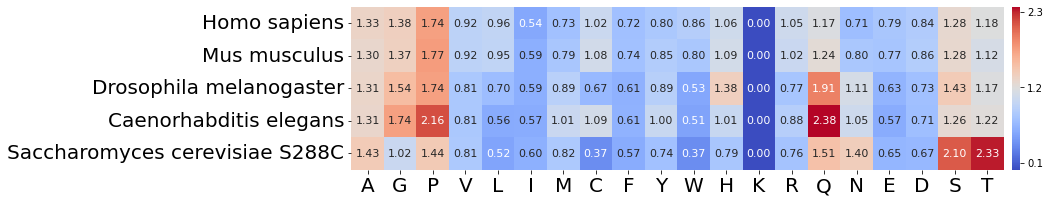

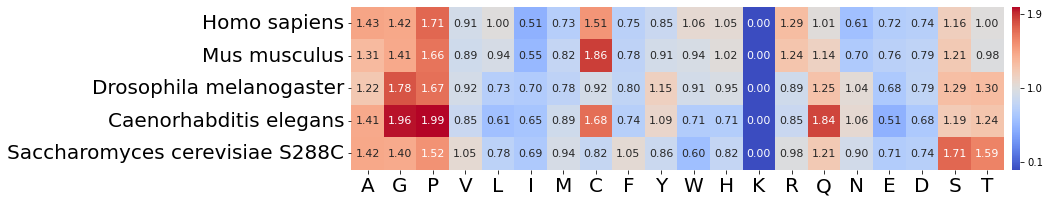

In [50]:
run_analysis_aa_frequencies('eukaryota', seq_min_length, 'whole_seq', TMH_max)
run_analysis_aa_frequencies('eukaryota', seq_min_length, 'desert_chunk', TMH_max)

## 5.5. Search for lysine clusters in selected Eukaryota proteomes

In [51]:
def plot_lusters_frequency(organisms, cluster_frac, desert_length):
    # function to add value labels
    def addlabels(x,y, z, desert_length):
        if desert_length == 0.5:
            h = 0.5
        elif desert_length == 150:
            h=0.2
        else:
            h = 0.05
        for i in range(len(x)):
            plt.text(i, y[i]+h, "{:.2f}".format(z[i])+'%', ha = 'center', fontsize=16)

    fig, ax = plt.subplots(figsize = (14,7))
    # creating the bar plot
    plt.bar(organisms, cluster_frac, color ='lightgrey',
            width = 0.4, edgecolor ='black', linewidth=3)

    addlabels(organisms ,cluster_frac, cluster_frac, desert_length)
    
    ax.set_xticklabels(['Saccharomyces\ncerevisiae S288C', 'Caenorhabditis\nelegans', 'Drosophila\nmelanogaster','Mus\nmusculus', 'Homo\nsapiens' ])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    if desert_length == 0.5:
        des_legend = '50%'
        plt.ylabel(f'Fraction among proteins\nwith lysine desert min. {des_legend} [%]', fontsize=24)
    elif desert_length == 150:
        des_legend = '150 aa'
        plt.ylabel(f'Fraction among proteins\nwith lysine desert min. {des_legend} [%]', fontsize=24)
    else:
         plt.ylabel(f'Fraction in proteome [%]', fontsize=24)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(f'results/lysine_clusters/eukaryota_lysine_clusters_among_lysine_deserts_{desert_length}.png', dpi=300, bbox_inches='tight')

    plt.show()
    plt.close('all')

### Co-occuring with lysine deserts

/var/folders/63/q2_r09gx5q1_k4n6r4pwry5w0000gn/T/ipykernel_49699/2261655292.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Saccharomyces\ncerevisiae S288C', 'Caenorhabditis\nelegans', 'Drosophila\nmelanogaster','Mus\nmusculus', 'Homo\nsapiens' ])


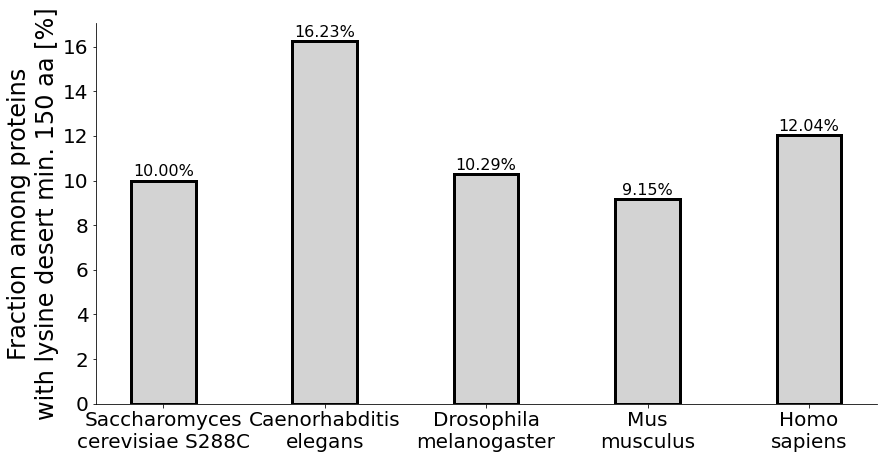

/var/folders/63/q2_r09gx5q1_k4n6r4pwry5w0000gn/T/ipykernel_49699/2261655292.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Saccharomyces\ncerevisiae S288C', 'Caenorhabditis\nelegans', 'Drosophila\nmelanogaster','Mus\nmusculus', 'Homo\nsapiens' ])


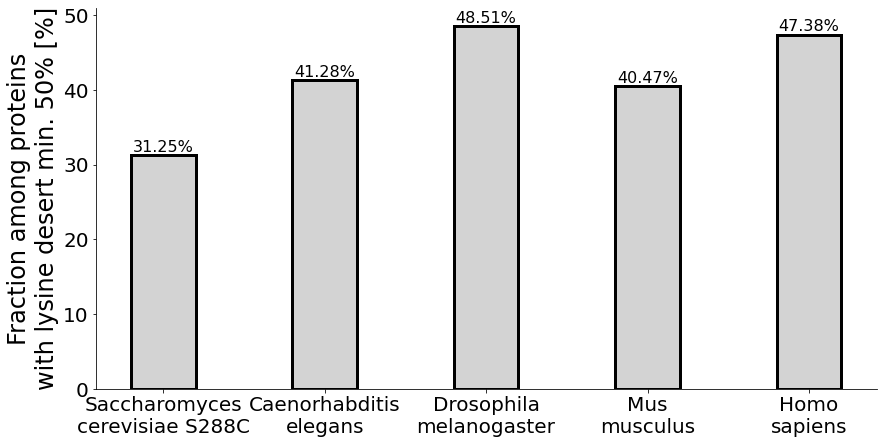

In [52]:
for des_length in desert_min_lengths:

    with open(f'results/trees/pickles/K_deserts/eukaryota_desert_{des_length}.pickle', 'rb') as handle:
        results = pickle.load(handle)
    cluster_frac = [0,0,0,0,0]
    organisms = ['Saccharomyces cerevisiae S288C', 'Caenorhabditis elegans', 'Drosophila melanogaster','Mus musculus', 'Homo sapiens' ]
    for k in results.keys():
        o = ncbi.get_taxid_translator([k])[int(k)]
        cluster_frac[organisms.index(o)] = results[k][3]

    plot_lusters_frequency(organisms, cluster_frac, des_length)

### In entire proteomes

(filtered as described in Selection criteria in par. 4)

/var/folders/63/q2_r09gx5q1_k4n6r4pwry5w0000gn/T/ipykernel_49699/2261655292.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Saccharomyces\ncerevisiae S288C', 'Caenorhabditis\nelegans', 'Drosophila\nmelanogaster','Mus\nmusculus', 'Homo\nsapiens' ])


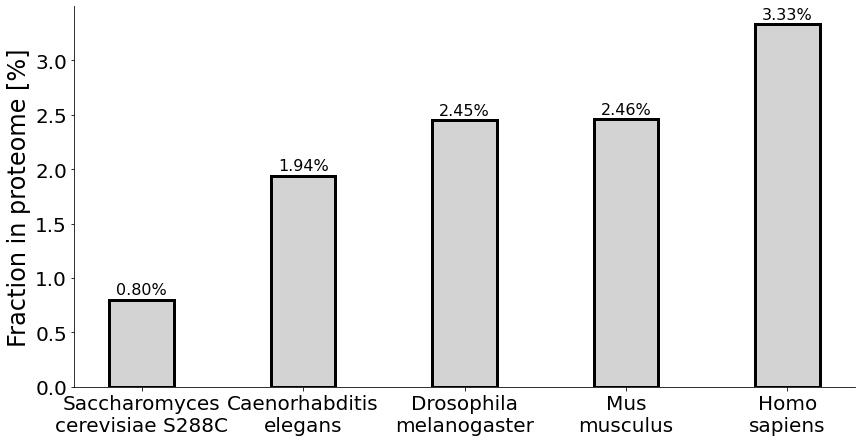

In [53]:
with open(f'results/trees/pickles/K_deserts/eukaryota_desert_150.pickle', 'rb') as handle:
    results = pickle.load(handle)
cluster_frac = [0,0,0,0,0]
organisms = ['Saccharomyces cerevisiae S288C', 'Caenorhabditis elegans', 'Drosophila melanogaster','Mus musculus', 'Homo sapiens' ]
for k in results.keys():
    o = ncbi.get_taxid_translator([k])[int(k)]
    cluster_frac[organisms.index(o)] = results[k][4]

plot_lusters_frequency(organisms, cluster_frac, 'proteome')

## 5.6. Search for lysine deserts among pupylated/non-pupylated proteins

Search for lysine deserts in *M. tuberculosis*, *M. smegmatis* and *C. glutamicum* proteomes, for which we have experimental data which sequences are pupylated and are not.

### Retrieve sequences of pupylated proteins

We cannot map Uniprot IDs from `pupdb_export.tab` on the previously downloaded proteomes (as described in `Download_data.ipynb`), because some of them are obsolete, meaning that they differ from those in reference proteomes files.

#### Prepare list of Uniprot IDs of pupylated proteins

In [204]:
%%bash

grep "Mycobacterium tuberculosis" data/pupdb_export.tab | cut -f1 > files/tmp_pup_tuberculosis.txt
grep "Mycobacterium smegmatis" data/pupdb_export.tab | cut -f1 > files/tmp_pup_smegmatis.txt
grep "Corynebacterium glutamicum" data/pupdb_export.tab | cut -f1 > files/tmp_pup_glutamicum.txt

#### Map Uniprot IDs to sequences

Open [Uniprot Retrieve/ID mapping](https://www.uniprot.org/uploadlists/) site. 

Paste there obtained Uniprot IDs of pupylated proteins (from the abovementioned `tmp_*` files) from each taxon and click submit.

After clicking submit, choose only sequences from *Mycobacterium tuberculosis (strain ATCC 25618 / H37Rv)* or *Mycolicibacterium smegmatis (strain ATCC 700084 / mc(2)155)* or *Corynebacterium glutamicum (strain ATCC 13032 / DSM 20300 / BCRC 11384 / JCM 1318 / LMG 3730 / NCIMB 10025)*; left panel Popular Organisms -> choose MYCTU/MYCS2/CARGL accordingly

---

Download results, gzip them and rename to `pupylated_83332.fasta.gz` (*M. tuberculosis*), `pupylated_246196.fasta.gz` (*M. smegmatis*) and `pupylated_196627.fasta.gz` (*C. glutamicum*) according to analyzed taxon's NCBI taxonomy ID. 

Save the files in directory `data/pupylome/pupylated_proteins/`


#### Delete unnecessary files

Delete temporary files with Uniprot IDs to map

In [205]:
%%bash
rm files/tmp_pup_tuberculosis.txt
rm files/tmp_pup_smegmatis.txt
rm files/tmp_pup_glutamicum.txt

### Prepare files with sequences of non-pupylated proteins and calculate fractions of pupylome

1. Create fasta files containing sequences of non-pupylated sequences separately for each taxon and save them to `data/pupylome/nonpupylated_proteins` directory. 

---

2. Prepare Table **Pupylome_summary.tsv** with calculated percentage of pupylated proteins in each proteome from selected taxons.


### Indexing

Supplementary tables are indexed by taxon name.

### Columns description

Supplementary tables contain the following information:

| Column  | Description  |
|:--|:--|
| **Number of proteins in proteome**  | Total number of proteins in proteome |
| **Number of pupylated proteins**  |  Number of pupylated proteins |
| **Fraction of pupylated proteins** | Fraction of pupylated proteins in proteome|


In [216]:
import gzip
from Bio import SeqIO

selected_bacteria = {'Mycobacterium tuberculosis' : ('83332', 'UP000001584_83332'), 
                     'Mycobacterium smegmatis' : ('246196','UP000000757_246196'), 
                     'Corynebacterium glutamicum' : ('196627','UP000000582_196627')}

sup_table = open('results/supplementary/Pupylome_summary.tsv', 'w')
sup_table.write('Taxon\tNumber of proteins in proteome\tNumber of pupylated proteins\tFraction of pupylated proteins\n')  

for taxon in selected_bacteria.keys():
    tax_id = selected_bacteria[taxon][0]
    proteome = selected_bacteria[taxon][1]
                     
    f1 = gzip.open('data/bacteria_proteomes/{}.fasta.gz'.format(proteome), 'rt')
    fasta_proteome = list(SeqIO.parse(f1, 'fasta'))
    f2 = gzip.open('data/pupylome/pupylated_proteins/pupylated_{}.fasta.gz'.format(tax_id), 'rt')
    fasta_pup = list(SeqIO.parse(f2, 'fasta'))            
                     
    out = open('data/pupylome/nonpupylated_proteins/nonpupylated_{}.fasta'.format(tax_id), 'w')
           
    pupylated_sequences = [str(seq.seq) for seq in fasta_pup]
    non_pup_counter = 0
    
    for seq in fasta_proteome:
        if str(seq.seq) not in pupylated_sequences:
            out.write('>{}\n'.format(seq.id))
            out.write('{}\n'.format(str(seq.seq)))
            non_pup_counter += 1
 
    out.close()
    sup_table.write('{}\t{}\t{}\t{}\n'.format(' '.join(taxon.split('_')), len(fasta_proteome), len(fasta_pup), round(len(fasta_pup)/len(fasta_proteome)*100, 2)))

sup_table.close()

In [217]:
%%bash

# Gzip created fasta files with nonpupylated sequences
for i in `ls data/pupylome/nonpupylated_proteins/`; do gzip -9 data/pupylome/nonpupylated_proteins/$i; done

###  Search for lysine desert regions among pupylated/non-pupylated proteins

Prepare Tables `Lysine_deserts_min_0.5_among_pupylated_proteins.tsv`, `Lysine_deserts_min_0.5_among_nonpupylated_proteins.tsv`,`Lysine_deserts_min_150_among_pupylated_proteins.tsv`, and `Lysine_deserts_min_150_among_nonpupylated_proteins.tsv` with calculated fraction of proteins with lysine desert of defined length among pupylated/nonpupylated proteins of selected taxons.

### Indexing

Supplementary tables are indexed by taxon name.

### Columns description

Supplementary tables contain the following information:

| Column  | Description  |
|:--|:--|
| **Total number of sequences**  | Total number of proteins in proteome |
| **Total number of filtered sequences**  |  Total number of filtered proteins in proteome (fulfilling default criteria of minimum length of 150 aa and maximum predicted TMH number of 2.0)  |
| **Average length of filtered sequences** | Average sequence length of filtered proteins|
| **Number of sequences with lysine desert** | Number of sequences which have defined lysine desert among pupylome or nonpupylome (both conditions indicated in the table's title)|
| **Fraction of sequences with lysine desert** | Fraction of proteins with defined lysine desert among pupylome or nonpupylome (both conditions indicated in the table's title) among filtered proteins |

In [221]:
selected_bacteria = {'Mycobacterium tuberculosis' : ('83332', 'UP000001584_83332'), 
                     'Mycobacterium smegmatis' : ('246196', 'UP000000757_246196'), 
                     'Corynebacterium glutamicum' : ('196627','UP000000582_196627')}

columns = ['Total number of sequences',
           'Total number of filtered sequences',
           'Average length of filtered sequences',
           'Number of sequences with lysine desert region',
           'Percentage of sequences with lysine desert region']

def search_pupylome(pup_status):

    for desert_length in desert_min_lengths:
        display(Markdown('# Lysine desert: {}'.format(desert_length)))
        results = {}

        for taxon in selected_bacteria.keys():
            tax_id = selected_bacteria[taxon][0]

            fasta_file = FindDesertProteome(f'data/pupylome/{pup_status}_proteins/{pup_status}_{tax_id}.fasta.gz', 'K')
            score = fasta_file.find_lysine_deserts_by_sequence(desert_length, seq_min_length, TMH_max)

            results[taxon] = [fasta_file.number, score[2], fasta_file.avg_seq_length(), score[1], score[0]]

        df = pd.DataFrame.from_dict(results, orient='index', columns=columns)
        df.index.name = 'Taxon'
        display(df)

        df.to_csv('results/supplementary/Lysine_deserts_min_{}_among_{}_proteins.tsv'.format(desert_length, pup_status), sep='\t')

In [222]:
search_pupylome('pupylated')

# Lysine desert: 150

,Total number of sequences,Total number of filtered sequences,Average length of filtered sequences,Number of sequences with lysine desert region,Percentage of sequences with lysine desert region
Taxon,,,,,
Mycobacterium tuberculosis,54,49,405.86,8,16.33
Mycobacterium smegmatis,76,66,406.83,2,3.03
Corynebacterium glutamicum,43,39,370.23,1,2.56


# Lysine desert: 0.5

,Total number of sequences,Total number of filtered sequences,Average length of filtered sequences,Number of sequences with lysine desert region,Percentage of sequences with lysine desert region
Taxon,,,,,
Mycobacterium tuberculosis,54,49,405.86,4,8.16
Mycobacterium smegmatis,76,66,406.83,1,1.52
Corynebacterium glutamicum,43,39,370.23,1,2.56


In [223]:
search_pupylome('nonpupylated')

# Lysine desert: 150

,Total number of sequences,Total number of filtered sequences,Average length of filtered sequences,Number of sequences with lysine desert region,Percentage of sequences with lysine desert region
Taxon,,,,,
Mycobacterium tuberculosis,3940,2729,386.62,842,30.85
Mycobacterium smegmatis,6524,4601,355.82,1341,29.15
Corynebacterium glutamicum,3050,1948,360.01,157,8.06


# Lysine desert: 0.5

,Total number of sequences,Total number of filtered sequences,Average length of filtered sequences,Number of sequences with lysine desert region,Percentage of sequences with lysine desert region
Taxon,,,,,
Mycobacterium tuberculosis,3940,2729,386.62,710,26.02
Mycobacterium smegmatis,6524,4601,355.82,1223,26.58
Corynebacterium glutamicum,3050,1948,360.01,185,9.50


## 5.7. Search for lysine deserts regions in selected phages groups

Search for lysine deserts in the prepared as described in `Download_data.ipynb` "one big proteomes" for each phages' group.

Plot barcharts of selected phages' groups and annotate it with fraction of sequences with lysine desert  calculated among all filtered sequences from particular phages' group (default ≥ 150 aa).


In [58]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown, display
%matplotlib inline

def make_barplot(x, y, values, X_axis_label, desert_length):
        
        display(Markdown('# Lysine desert: {}'.format(desert_length)))
        
        
        kwargs  =   {'edgecolor':"black", 
                     'linewidth':3}

        f, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
        plt.tight_layout()

        bar = sns.barplot(x = x, y = y , color='lightgrey',**kwargs)
        plt.yticks(fontsize=20)

        ax.set(xlabel=X_axis_label, ylabel='', title='')
        ax.grid(False)
        sns.set_style("ticks")
        major_ticks = np.arange(0, 16, 2)
        ax.xaxis.label.set_size(24)

        ax.set_xticks(major_ticks)
        plt.xticks(fontsize=20)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Annotate bars
        c = 0
        for p in bar.patches:
            width = p.get_width()
            bar.annotate((str(round(values[c][0], 2)) + '/' + str(round(values[c][1], 2))), xy=(p.get_width(), p.get_y()+p.get_height()/2),
                         xytext=(5, 0), textcoords='offset points', ha="left", va="center", fontsize=16)
            c += 1

        plt.show()
        f.savefig(f'results/charts/phages_lysine_deserts_{desert_length}.png', dpi=600, bbox_inches='tight')
        plt.close('all')

# Lysine desert: 150

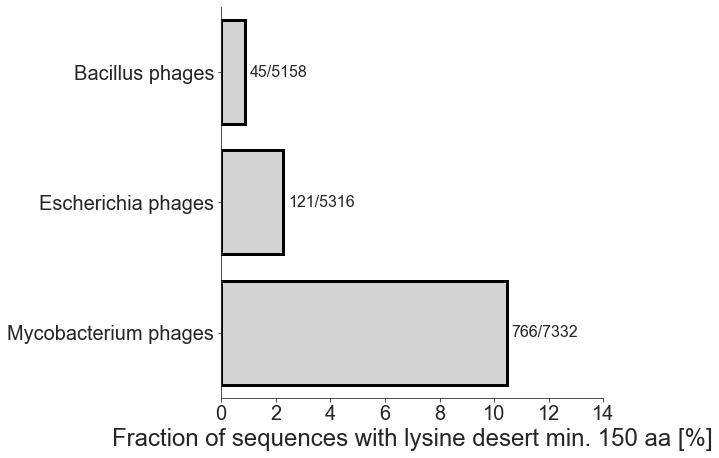

# Lysine desert: 0.5

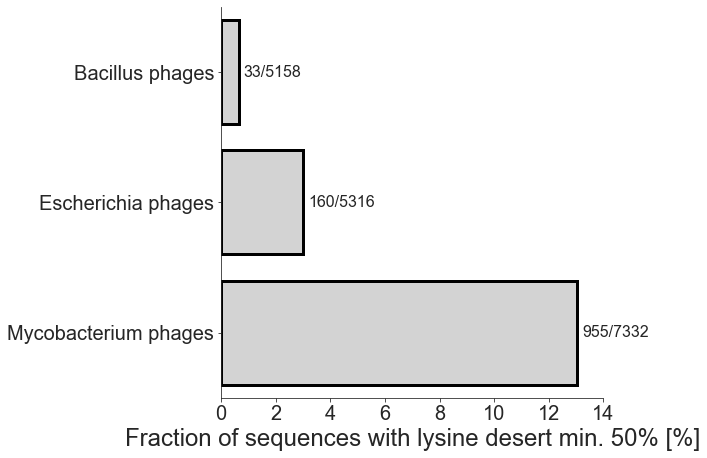

In [59]:
y = ['Bacillus phages', 'Escherichia phages', 'Mycobacterium phages']
columns = ['Percentage of sequences with lysine desert region', 'Number of sequences with lysine desert region', 'Total number of filtered sequences']

for desert_length in desert_min_lengths:
    results = {}
    
    if desert_length == 150:
        desert_length_name_to_save = '150 aa'
    elif desert_length == 0.5:
        desert_length_name_to_save = '50%'
    else:
        pass
    
    for group in ['bacillus', 'escherichia', 'mycobacterium']:
        fasta_file = FindDesertProteome('data/Phages_proteomes/after_cd-hit/{}/clustered_proteome.fasta.gz'.format(group), 'K')
        score = fasta_file.find_lysine_deserts_by_sequence(desert_length, seq_min_length, None)
        
        results[group] = score[:3]

    df = pd.DataFrame.from_dict(results, orient='index', columns=columns)
    annot = list(zip(df['Number of sequences with lysine desert region'].values, df['Total number of filtered sequences'].values))
    
    make_barplot(df['Percentage of sequences with lysine desert region'], y, annot, 'Fraction of sequences with lysine desert min. {} [%]'.format(desert_length_name_to_save), desert_length)